In [18]:
import numpy as np

from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.metrics import (roc_auc_score, 
                             accuracy_score)

from run_test import ( set_seed, 
                       na_imputer,
                       RealNormalizer,
                       data_processing )

from data_processor import get_low_variance_objects

from sklearn.linear_model import LogisticRegression, Ridge, Lasso


import autogluon as ag
from autogluon import TabularPrediction as task

import matplotlib.pyplot as plt
from scipy import stats

## This notebook is only to check AutoGluon's internal feature pre preprocessing to further mbenchmarking
## AutoGluon applies feature transformations specific for all models

In [33]:
import pandas as pd

TRAIN_PATH = '../../../data_main/credit/TRAIN.csv'
VAL_PATH = '../../../data_main/credit/VAL.csv'
train = pd.read_csv(TRAIN_PATH)#.sample(10000)
val = pd.read_csv(VAL_PATH)#.sample(3000)

val.drop(['Unnamed: 0','Unnamed: 0.1'], axis=1, inplace=True)
train.drop(['Unnamed: 0','Unnamed: 0.1'], axis=1, inplace=True)

train.fillna(train.median(), inplace=True)
val.fillna(train.median(), inplace=True)

TARGET = 'TARGET'

In [20]:
class RealNormalizer:
    def __init__(self):
        self.mapper = dict()
    
    def fit_transform(self, data, columns_to_normalize):
        for col in columns_to_normalize:
            mean, std = data[col].mean(), data[col].std()
            if std == 0: continue
            self.mapper[col] = (mean, std)          
            data[col] = ((data[col] - mean)/std).astype(float)
        
        return data
    
    def transform(self, data):
        for col in self.mapper:
            mean, std = self.mapper[col]
            data[col] = ((data[col] - mean)/std).astype(float)
        
        return data

In [21]:
class MinMax:
    def __init__(self):
        self.mapper = dict()
    
    def fit_transform(self, data, columns_to_normalize):
        for col in columns_to_normalize:
            min_, diff = data[col].min(), data[col].max() - data[col].min()
            self.mapper[col] = (min_, diff)          
            data[col] = ((data[col] - min_)/(diff)).astype(float)
        
        return data
    
    def transform(self, data):
        for col in self.mapper:
            min_, diff = self.mapper[col]
            data[col] = ((data[col] - min_)/(diff)).astype(float)
        
        return data

### LR regression no preprocessing

In [22]:
model = LogisticRegression(penalty ='l2',random_state = 0,solver = 'lbfgs',n_jobs = -1, C=1)

model.fit(train.drop(TARGET, axis=1), train[TARGET])
preds = model.predict_proba(val.drop(TARGET, axis=1))
roc_auc_score(val[TARGET], preds[:,1])

0.6566318124140056

### TRAIN AUTO GLUON on the same features

In [23]:
hyperparameters = {'LR':{}}

predictor = task.fit(train_data=train, 
                     output_directory="a_gluon_tests", 
                     label=TARGET, 
                     eval_metric='roc_auc', 
                     hyperparameters=hyperparameters,
                     verbosity = 0)
                     #num_bagging_folds=None,
                     #num_bagging_sets=None,)

In [24]:
performance = predictor.evaluate(val)

Predictive performance on given dataset: roc_auc = 0.8371281065863232


### TRANSFORM FEATURES (Apply similar transformations auto gluon does internlly)

In [26]:
low_var_objects, high_var_objects, low_var_real = get_low_variance_objects(train.drop(TARGET, axis=1), th=100)

Low variance items all: 7, Objects all: 0
Low variance objects: 0, High var objects: 0


In [27]:
categoical = low_var_objects.union(low_var_real)
low_var_n_objects = categoical.union(high_var_objects)
real_features = list(set(train.columns).difference(low_var_n_objects))
real_features.remove(TARGET)

In [28]:
train  = pd.get_dummies(train, columns=categoical)
val  = pd.get_dummies(val, columns=categoical)

train, val = train.align(val, join='outer', axis=1, fill_value=0)

print(train.shape)
print(val.shape)

(89968, 235)
(30263, 235)


### APPLY BOX COX

###  Real valued features before BOX COX

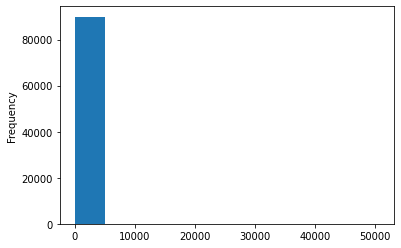

In [34]:
train[real_features[1]].plot(kind='hist')

In [37]:
normalizer = MinMax()

# box cox
# transform training data & save lambda value
train[real_features[2]],fitted_lambda = stats.boxcox(train[real_features[2]]+1)
# use lambda value to transform test data
val[real_features[2]] = stats.boxcox(val[real_features[2]]+1, fitted_lambda)

train[real_features[1]],fitted_lambda = stats.boxcox(train[real_features[1]]+1)
val[real_features[1]] = stats.boxcox(val[real_features[1]]+1, fitted_lambda)
 
# SCORE if higher if do not do this transformation

# transform training data & save lambda value
# train[real_features[0]],fitted_lambda = stats.boxcox(train[real_features[0]]+1)
# use lambda value to transform test data
# val[real_features[0]] = stats.boxcox(val[real_features[0]]+1, fitted_lambda)

# min max
train = normalizer.fit_transform(train, real_features)
val = normalizer.transform(val)

###  Real valued features after BOX COX

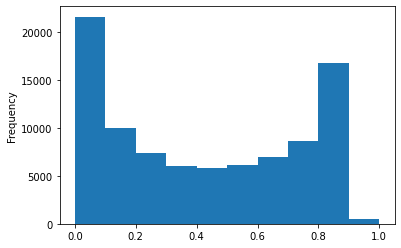

In [38]:
train[real_features[1]].plot(kind='hist')

In [14]:
model = LogisticRegression(penalty ='l2',random_state = 0, solver = 'lbfgs',n_jobs = -1, max_iter=50)

model.fit(train.drop(TARGET, axis=1), train[TARGET])
preds = model.predict_proba(val.drop(TARGET, axis=1))
roc_auc_score(val[TARGET], preds[:,1])

0.8562655449681559

### AUTO GLUON ON THE SAME FEATURES
##### Auto gluon has a threshold for skewed data to apply box cox

In [39]:
hyperparameters = {'LR':{}}

predictor = task.fit(train_data=train, 
                     output_directory="a_gluon_tests", 
                     label=TARGET, 
                     eval_metric='roc_auc', 
                     hyperparameters=hyperparameters,
                     verbosity = 0)
                     #num_bagging_folds=None,
                     #num_bagging_sets=None,)
        
performance = predictor.evaluate(val)

Predictive performance on given dataset: roc_auc = 0.8471889775967005


### CHECK AutoGluon params

In [218]:
predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model  score_val  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer
0              LinearModel    0.86819       0.435163  52.335602                0.435163          52.335602            0       True
1  weighted_ensemble_k0_l1    0.86819       0.437831  52.339645                0.002668           0.004043            1       True
Number of models trained: 2
Types of models trained:
{'LinearModel', 'WeightedEnsembleModel'}
Bagging used: False 
Stack-ensembling used: False 
Hyperparameter-tuning used: False 
User-specified hyperparameters:
{'default': {'LR': [{}]}}
Plot summary of models saved to file: a_gluon_tests/SummaryOfModels.html
*** End of fit() summary ***


{'model_types': {'LinearModel': 'LinearModel',
  'weighted_ensemble_k0_l1': 'WeightedEnsembleModel'},
 'model_performance': {'LinearModel': 0.8681899861145144,
  'weighted_ensemble_k0_l1': 0.8681899861145144},
 'model_best': 'weighted_ensemble_k0_l1',
 'model_paths': {'LinearModel': 'a_gluon_tests/models/LinearModel/',
  'weighted_ensemble_k0_l1': 'a_gluon_tests/models/weighted_ensemble_k0_l1/'},
 'model_fit_times': {'LinearModel': 52.335602045059204,
  'weighted_ensemble_k0_l1': 0.0040433406829833984},
 'model_pred_times': {'LinearModel': 0.4351630210876465,
  'weighted_ensemble_k0_l1': 0.002668142318725586},
 'num_bagging_folds': 0,
 'stack_ensemble_levels': 0,
 'feature_prune': False,
 'hyperparameter_tune': False,
 'hyperparameters_userspecified': {'default': {'LR': [{}]}},
 'num_classes': 2,
 'model_hyperparams': {'LinearModel': {'C': 1,
   'vectorizer_dict_size': 75000,
   'proc.ngram_range': (1, 5),
   'proc.skew_threshold': 0.99,
   'proc.impute_strategy': 'median',
   'penalty